In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# -----------------------------
# LOAD & PREPARE DATA
# -----------------------------
# Two datasets: carbon_intensity, gdp_per_capita
ci   = pd.read_csv('carbon_intensity.csv')
gdp_pc = pd.read_csv('gdp_per_capita.csv')

# Convert wide → long if needed
def prep(df, value_name):
    if 'year' not in df.columns:
        df = df.melt(id_vars='country', var_name='year', value_name=value_name)
    # Numeric year
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    return df

ci = prep(ci, 'carbon_intensity')
gdp_pc = prep(gdp_pc, 'gdp_per_capita')

# Numeric conversion for carbon_intensity
gi = pd.to_numeric(ci['carbon_intensity'], errors='coerce')
ci['carbon_intensity'] = gi

# Convert 'k' in gdp_per_capita to thousands and numeric
gdp_pc['gdp_per_capita'] = (
    gdp_pc['gdp_per_capita'].astype(str)
         .str.replace('k', 'e3')
         .pipe(pd.to_numeric, errors='coerce')
)

# Merge & drop missing
df = ci.merge(gdp_pc, on=['country','year']).dropna(subset=['carbon_intensity','gdp_per_capita'])


Year 2023: GDP per capita median=16200.00


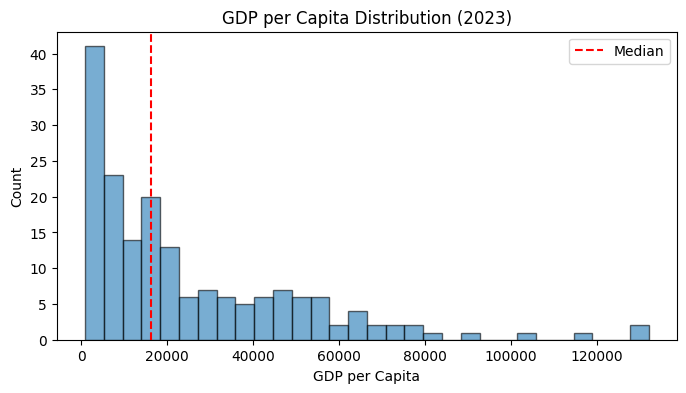

NP Median: est=16200.00, se=1590.40, 95% CI=(13200.00, 19900.00)
P Median: est=16200.00, se=2379.94, 95% CI=(11709.42, 20876.39)


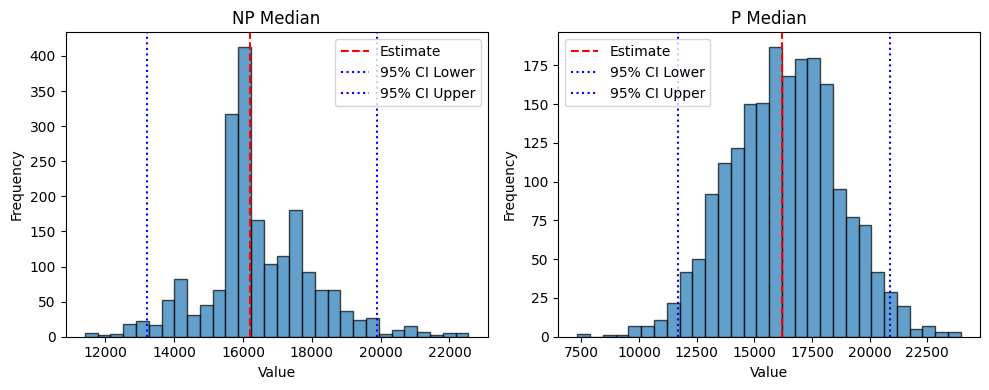

Income thresholds from median CI: low < 11709.42, high > 20876.39
income_group
High      74
Low       71
Medium    33
Name: count, dtype: int64


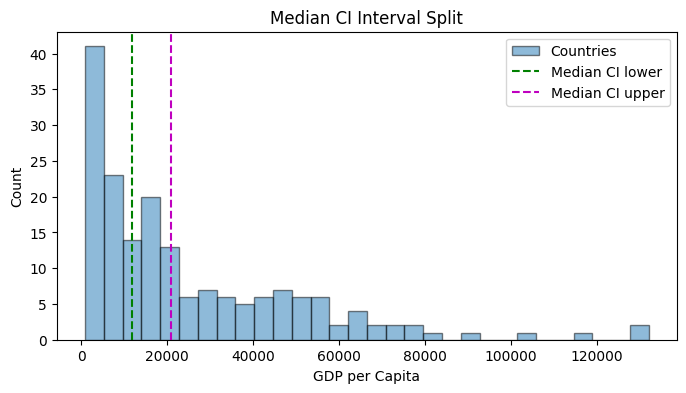

In [4]:
# -----------------------------
# ANALYZE GDP PER CAPITA: DEFINE INCOME GROUPS
# -----------------------------
# Select latest year
year = int(df['year'].max())
df_year = df[df['year']==year].copy()

gdp = df_year['gdp_per_capita']
# Keep only median
med_gdp = gdp.median()
print(f"Year {year}: GDP per capita median={med_gdp:.2f}")

# Plot distribution with median only
plt.figure(figsize=(8,4))
plt.hist(gdp, bins=30, edgecolor='k', alpha=0.6)
plt.axvline(med_gdp, color='red', linestyle='--', label='Median')
plt.xlabel('GDP per Capita')
plt.ylabel('Count')
plt.title(f'GDP per Capita Distribution ({year})')
plt.legend()
plt.show()

# Bootstrap for uncertainty
B = 2000
# Nonparametric bootstrap for median
boot_np_med = np.array([gdp.sample(len(gdp), replace=True).median() for _ in range(B)])
# Parametric bootstrap for median via normal approximation
s = gdp.std(ddof=1)
sims = np.random.normal(med_gdp, s, size=(len(gdp), B))
boot_p_med = np.median(sims, axis=0)

# Summarize bootstrap results (median only)
def summarize(boot_values, point_est):
    se = boot_values.std(ddof=1)
    ci = np.percentile(boot_values, [2.5, 97.5])
    return point_est, se, ci

results = {
    'NP Median': summarize(boot_np_med, med_gdp),
    'P Median': summarize(boot_p_med, med_gdp)
}

for name, (est, se, ci) in results.items():
    print(f"{name}: est={est:.2f}, se={se:.2f}, 95% CI=({ci[0]:.2f}, {ci[1]:.2f})")

# Plot bootstrap distributions for median only
fig, axes = plt.subplots(1, 2, figsize=(10,4))
plot_data = [boot_np_med, boot_p_med]
plot_titles = ['NP Median', 'P Median']
for ax, data, title in zip(axes, plot_data, plot_titles):
    est, se, ci = results[title]
    ax.hist(data, bins=30, edgecolor='k', alpha=0.7)
    ax.axvline(est, color='r', linestyle='--', label='Estimate')
    ax.axvline(ci[0], color='b', linestyle=':', label='95% CI Lower')
    ax.axvline(ci[1], color='b', linestyle=':', label='95% CI Upper')
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
plt.tight_layout()
plt.show()

# Determine median CI bounds as income thresholds
low_thr, high_thr = results['P Median'][2]
print(f"Income thresholds from median CI: low < {low_thr:.2f}, high > {high_thr:.2f}")

# Assign groups based on thresholds
bins = [-np.inf, low_thr, high_thr, np.inf]
labels = ['Low','Medium','High']
df_year['income_group'] = pd.cut(df_year['gdp_per_capita'], bins=bins, labels=labels)
print(df_year['income_group'].value_counts())

# Visualize groups on histogram
plt.figure(figsize=(8,4))
df_year['gdp_per_capita'] = pd.to_numeric(df_year['gdp_per_capita'], errors='coerce')
plt.hist(df_year['gdp_per_capita'].dropna(), bins=30, edgecolor='k', alpha=0.5, label='Countries')
plt.axvline(low_thr, color='g', linestyle='--', label='Median CI lower')
plt.axvline(high_thr, color='m', linestyle='--', label='Median CI upper')
plt.xlabel('GDP per Capita')
plt.ylabel('Count')
plt.title('Median CI Interval Split')
plt.legend()
plt.show()

<ipython-input-9-1247742981>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df_groups.groupby('income_group')['carbon_intensity'].agg(
<ipython-input-9-1247742981>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = sample.groupby('income_group')['carbon_intensity'].median()


Group Statistics:
High Income Median: 0.1325
Low Income Median: 0.1150
Median Difference (High - Low): 0.0175
Median Ratio (Low/High): 0.8679

Bootstrap Results:
High Median: 0.1325 ± 0.0140
95% CI: [0.1140, 0.1645]
Z-score: 9.44 (Significant)

Low Median: 0.1150 ± 0.0098
95% CI: [0.1050, 0.1460]
Z-score: 11.68 (Significant)

Median Difference: 0.0175 ± 0.0168
95% CI: [-0.0155, 0.0520]
Z-score: 1.04 (Not significant)

Median Ratio: 0.8679 ± 0.1132
95% CI: [0.6808, 1.1231]
Z-score: 7.66 (Significant)


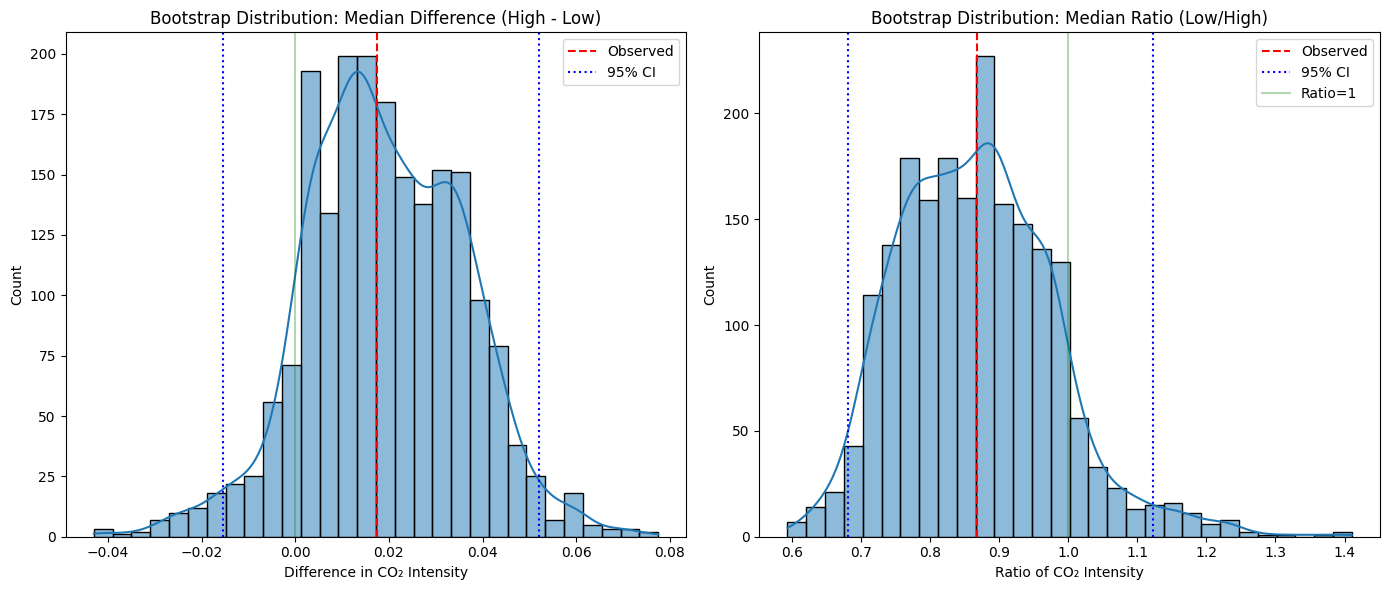

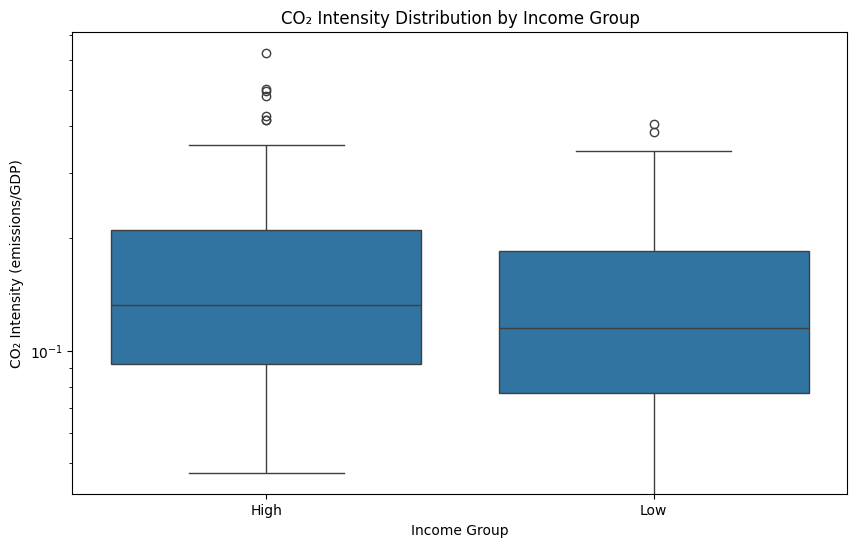

In [9]:
import seaborn as sns
# ------------------------------------------------------------
# STEP 1: GROUP STATISTICS, DIFFERENCES, RATIOS & BOOTSTRAP
# ------------------------------------------------------------

# Filter data to only High and Low income groups
df_groups = df_year[df_year['income_group'].isin(['High', 'Low'])]

# Calculate group statistics
group_stats = df_groups.groupby('income_group')['carbon_intensity'].agg(
    median='median'
).reset_index()

# Extract values for High and Low groups
high_median = group_stats[group_stats['income_group'] == 'High']['median'].values[0]
low_median = group_stats[group_stats['income_group'] == 'Low']['median'].values[0]

# Calculate differences and ratios
median_diff = high_median - low_median
median_ratio = low_median / high_median

print("Group Statistics:")
print(f"High Income Median: {high_median:.4f}")
print(f"Low Income Median: {low_median:.4f}")
print(f"Median Difference (High - Low): {median_diff:.4f}")
print(f"Median Ratio (Low/High): {median_ratio:.4f}")

# Bootstrap function for group statistics
def bootstrap_group_stats(df, n_boot=2000):
    boot_results = {
        'high_medians': [],
        'low_medians': [],
        'median_diffs': [],
        'median_ratios': []
    }

    for _ in range(n_boot):
        # Resample entire dataset with replacement
        sample = df.sample(frac=1, replace=True)

        # Group statistics
        group_medians = sample.groupby('income_group')['carbon_intensity'].median()

        high_med = group_medians.get('High', np.nan)
        low_med = group_medians.get('Low', np.nan)

        if not np.isnan(high_med) and not np.isnan(low_med):
            boot_results['high_medians'].append(high_med)
            boot_results['low_medians'].append(low_med)
            boot_results['median_diffs'].append(high_med - low_med)
            boot_results['median_ratios'].append(low_med / high_med)

    return {k: np.array(v) for k, v in boot_results.items()}

# Run bootstrap
boot_results = bootstrap_group_stats(df_groups)

# Calculate summary statistics
def bootstrap_summary(observed, boot_values):
    se = np.std(boot_values)
    ci = np.percentile(boot_values, [2.5, 97.5])
    z_score = observed / se
    return {
        'observed': observed,
        'se': se,
        'ci_low': ci[0],
        'ci_high': ci[1],
        'z_score': z_score
    }

# Create summaries
summary_high = bootstrap_summary(high_median, boot_results['high_medians'])
summary_low = bootstrap_summary(low_median, boot_results['low_medians'])
summary_diff = bootstrap_summary(median_diff, boot_results['median_diffs'])
summary_ratio = bootstrap_summary(median_ratio, boot_results['median_ratios'])

print("\nBootstrap Results:")

print(f"High Median: {summary_high['observed']:.4f} ± {summary_high['se']:.4f}")
print(f"95% CI: [{summary_high['ci_low']:.4f}, {summary_high['ci_high']:.4f}]")
print(f"Z-score: {summary_high['z_score']:.2f} ({'Significant' if abs(summary_high['z_score']) > 1.96 else 'Not significant'})")

print(f"\nLow Median: {summary_low['observed']:.4f} ± {summary_low['se']:.4f}")
print(f"95% CI: [{summary_low['ci_low']:.4f}, {summary_low['ci_high']:.4f}]")
print(f"Z-score: {summary_low['z_score']:.2f} ({'Significant' if abs(summary_low['z_score']) > 1.96 else 'Not significant'})")

print(f"\nMedian Difference: {summary_diff['observed']:.4f} ± {summary_diff['se']:.4f}")
print(f"95% CI: [{summary_diff['ci_low']:.4f}, {summary_diff['ci_high']:.4f}]")
print(f"Z-score: {summary_diff['z_score']:.2f} ({'Significant' if abs(summary_diff['z_score']) > 1.96 else 'Not significant'})")

print(f"\nMedian Ratio: {summary_ratio['observed']:.4f} ± {summary_ratio['se']:.4f}")
print(f"95% CI: [{summary_ratio['ci_low']:.4f}, {summary_ratio['ci_high']:.4f}]")
print(f"Z-score: {summary_ratio['z_score']:.2f} ({'Significant' if abs(summary_ratio['z_score']) > 1.96 else 'Not significant'})")

# Plot bootstrap distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Difference plot
sns.histplot(boot_results['median_diffs'], bins=30, ax=axes[0], kde=True)
axes[0].axvline(summary_diff['observed'], color='r', linestyle='--', label='Observed')
axes[0].axvline(summary_diff['ci_low'], color='b', linestyle=':', label='95% CI')
axes[0].axvline(summary_diff['ci_high'], color='b', linestyle=':')
axes[0].axvline(0, color='g', linestyle='-', alpha=0.3)
axes[0].set_title('Bootstrap Distribution: Median Difference (High - Low)')
axes[0].set_xlabel('Difference in CO₂ Intensity')
axes[0].legend()

# Ratio plot
sns.histplot(boot_results['median_ratios'], bins=30, ax=axes[1], kde=True)
axes[1].axvline(summary_ratio['observed'], color='r', linestyle='--', label='Observed')
axes[1].axvline(summary_ratio['ci_low'], color='b', linestyle=':', label='95% CI')
axes[1].axvline(summary_ratio['ci_high'], color='b', linestyle=':')
axes[1].axvline(1, color='g', linestyle='-', alpha=0.3, label='Ratio=1')
axes[1].set_title('Bootstrap Distribution: Median Ratio (Low/High)')
axes[1].set_xlabel('Ratio of CO₂ Intensity')
axes[1].legend()

plt.tight_layout()
plt.show()

# Boxplot comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='income_group', y='carbon_intensity', data=df_groups, order=['High', 'Low'])
plt.title('CO₂ Intensity Distribution by Income Group')
plt.ylabel('CO₂ Intensity (emissions/GDP)')
plt.xlabel('Income Group')
plt.yscale('log')
plt.show()

Pearson Correlation: -0.0229
Spearman Correlation: 0.0987

Quadratic Regression Results:
R-squared: 0.1342
Intercept: -16.2285
GDP coefficient: 2.9885
GDP² coefficient: -0.1542
Turning Point (GDP per capita): $16209.33


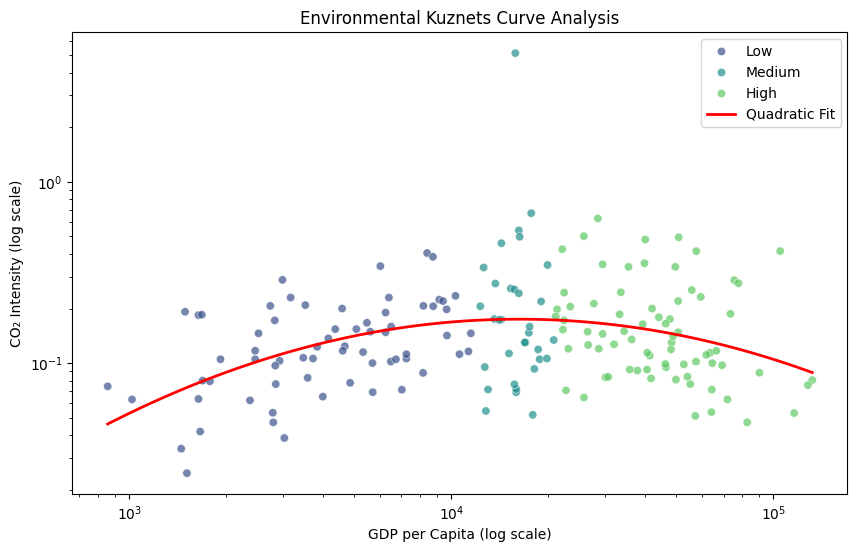


Bootstrap Results for EKC Analysis:
Pearson Correlation: -0.0229 ± 0.0528
95% CI: [-0.0928, 0.1280]
Z-score: -0.43

Spearman Correlation: 0.0987 ± 0.0832
95% CI: [-0.0677, 0.2601]
Z-score: 1.19

Quadratic Term: -0.1542 ± 0.0357
95% CI: [-0.2295, -0.0873]
Z-score: -4.32 (Significant)

Turning Point: $16209.33 ± 3475.38
95% CI: [$12646.53, $24957.19]


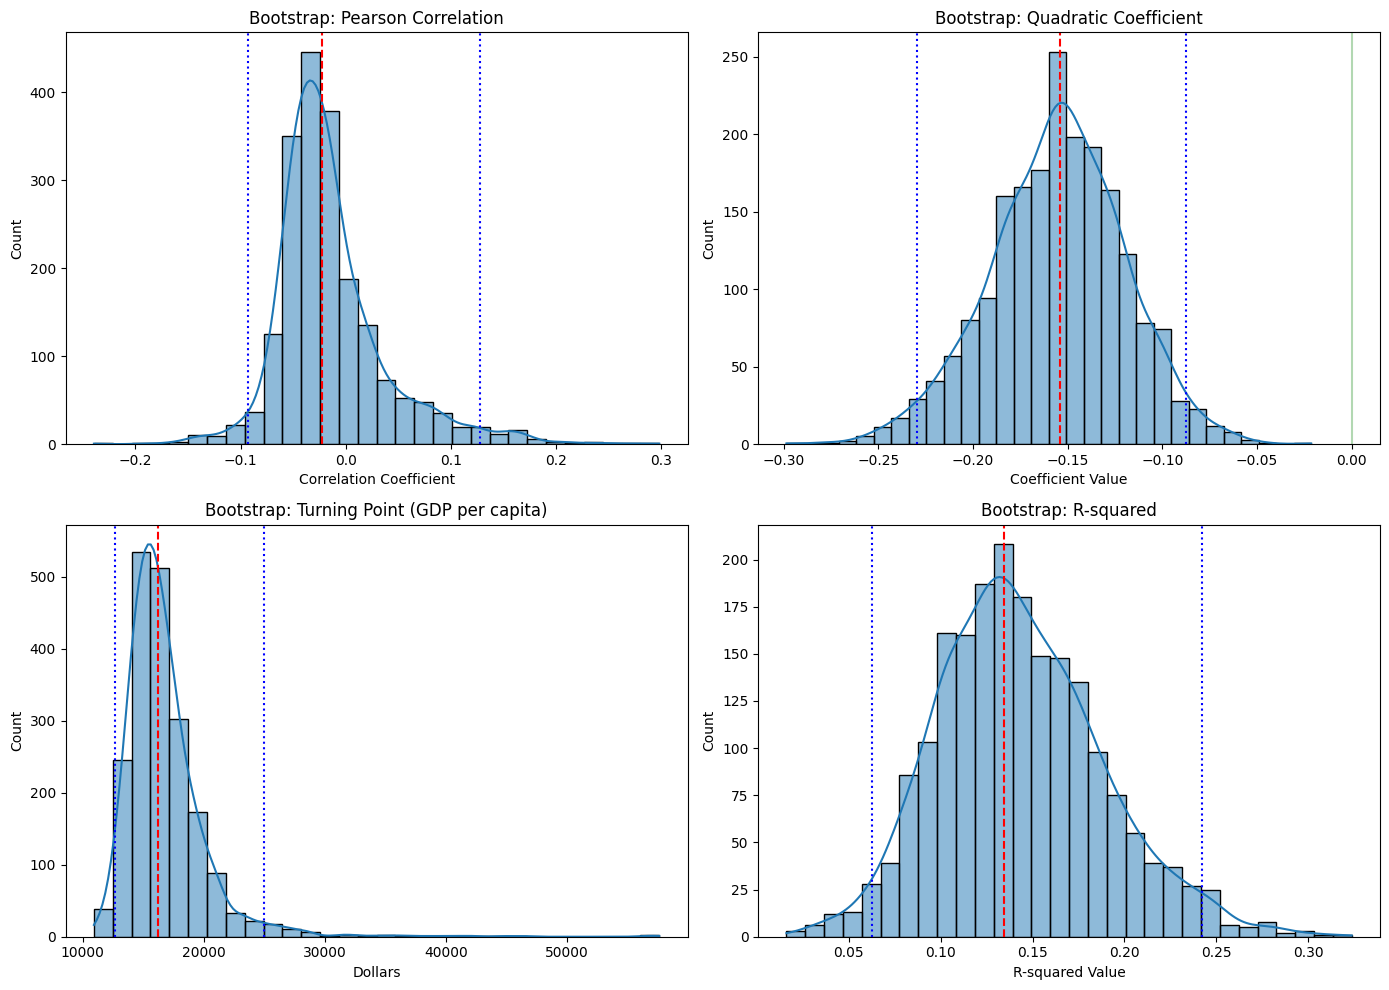

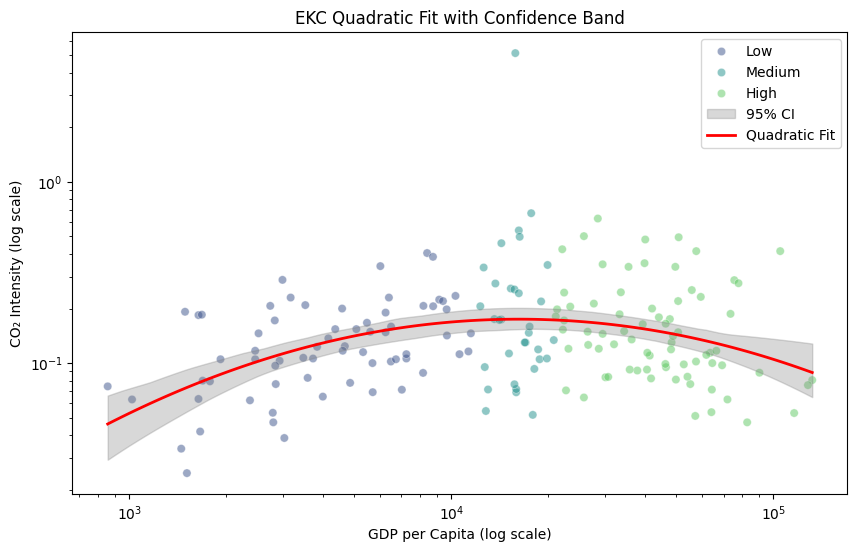

In [ ]:
# ------------------------------------------------------------
# STEP 2: CO2 INTENSITY VS GDP PER CAPITA (EKC ANALYSIS)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Drop rows where gdp_per_capita or carbon_intensity are non-positive
df_year = df_year[(df_year['gdp_per_capita'] > 0) & (df_year['carbon_intensity'] > 0)].copy()

# Create log-transformed variables for better visualization
df_year['log_gdp'] = np.log(df_year['gdp_per_capita'])
df_year['log_carbon'] = np.log(df_year['carbon_intensity'])

# Scatter plot with regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_per_capita', y='carbon_intensity', hue='income_group',
                data=df_year, palette='viridis', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP per Capita (log scale)')
plt.ylabel('CO₂ Intensity (log scale)')
plt.title('Environmental Kuznets Curve Analysis')

# Calculate correlation metrics
pearson_corr = df_year[['gdp_per_capita', 'carbon_intensity']].corr(method='pearson').iloc[0, 1]
spearman_corr = df_year[['gdp_per_capita', 'carbon_intensity']].corr(method='spearman').iloc[0, 1]

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

# Quadratic regression model
X = df_year[['log_gdp']].copy()
X['log_gdp_sq'] = X['log_gdp'] ** 2
y = df_year['log_carbon']

# Fit model
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)

# Get coefficients
coef_gdp = model.coef_[0]
coef_gdp_sq = model.coef_[1]
intercept = model.intercept_

print("\nQuadratic Regression Results:")
print(f"R-squared: {r_squared:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"GDP coefficient: {coef_gdp:.4f}")
print(f"GDP² coefficient: {coef_gdp_sq:.4f}")

# Calculate turning point (peak of EKC)
turning_point = np.exp(-coef_gdp / (2 * coef_gdp_sq))
print(f"Turning Point (GDP per capita): ${turning_point:.2f}")

# Generate predictions for plotting
x_range = np.linspace(df_year['log_gdp'].min(), df_year['log_gdp'].max(), 100)
X_pred = pd.DataFrame({
    'log_gdp': x_range,
    'log_gdp_sq': x_range ** 2
})
y_pred = model.predict(X_pred)

# Convert back to original scale for plotting
gdp_range = np.exp(x_range)
carbon_pred = np.exp(y_pred)

# Add regression line to plot
plt.plot(gdp_range, carbon_pred, 'r-', linewidth=2, label='Quadratic Fit')
plt.legend()
plt.show()

# Bootstrap regression metrics
def bootstrap_regression(df, n_boot=2000):
    boot_results = {
        'pearson': [],
        'spearman': [],
        'gdp_coef': [],
        'gdp_sq_coef': [],
        'turning_point': [],
        'r_squared': [],
        'model_intercept': []
    }

    for _ in range(n_boot):
        sample = df.sample(frac=1, replace=True)

        # Correlations
        boot_results['pearson'].append(sample[['gdp_per_capita', 'carbon_intensity']].corr(method='pearson').iloc[0, 1])
        boot_results['spearman'].append(sample[['gdp_per_capita', 'carbon_intensity']].corr(method='spearman').iloc[0, 1])

        # Regression
        X = sample[['log_gdp']].copy()
        X['log_gdp_sq'] = X['log_gdp'] ** 2
        y = sample['log_carbon']

        model = LinearRegression()
        model.fit(X, y)

        # Store intercept
        boot_results['model_intercept'].append(model.intercept_)

        r_sq = model.score(X, y)
        gdp_coef = model.coef_[0]
        gdp_sq_coef = model.coef_[1]

        boot_results['gdp_coef'].append(gdp_coef)
        boot_results['gdp_sq_coef'].append(gdp_sq_coef)
        boot_results['r_squared'].append(r_sq)

        # Calculate turning point if quadratic coefficient is negative
        if gdp_sq_coef < 0:
            tp = np.exp(-gdp_coef / (2 * gdp_sq_coef))
            boot_results['turning_point'].append(tp)

    return boot_results

# Run bootstrap
boot_reg = bootstrap_regression(df_year)

# Create summaries
summary_pearson = bootstrap_summary(pearson_corr, boot_reg['pearson'])
summary_spearman = bootstrap_summary(spearman_corr, boot_reg['spearman'])
summary_gdp_sq = bootstrap_summary(coef_gdp_sq, boot_reg['gdp_sq_coef'])
summary_tp = bootstrap_summary(turning_point, boot_reg['turning_point'])

print("\nBootstrap Results for EKC Analysis:")
print(f"Pearson Correlation: {summary_pearson['observed']:.4f} ± {summary_pearson['se']:.4f}")
print(f"95% CI: [{summary_pearson['ci_low']:.4f}, {summary_pearson['ci_high']:.4f}]")
print(f"Z-score: {summary_pearson['z_score']:.2f}")

print(f"\nSpearman Correlation: {summary_spearman['observed']:.4f} ± {summary_spearman['se']:.4f}")
print(f"95% CI: [{summary_spearman['ci_low']:.4f}, {summary_spearman['ci_high']:.4f}]")
print(f"Z-score: {summary_spearman['z_score']:.2f}")

print(f"\nQuadratic Term: {summary_gdp_sq['observed']:.4f} ± {summary_gdp_sq['se']:.4f}")
print(f"95% CI: [{summary_gdp_sq['ci_low']:.4f}, {summary_gdp_sq['ci_high']:.4f}]")
print(f"Z-score: {summary_gdp_sq['z_score']:.2f} ({'Significant' if abs(summary_gdp_sq['z_score']) > 1.96 else 'Not significant'})")

print(f"\nTurning Point: ${summary_tp['observed']:.2f} ± {summary_tp['se']:.2f}")
print(f"95% CI: [${summary_tp['ci_low']:.2f}, ${summary_tp['ci_high']:.2f}]")

# Plot bootstrap distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pearson correlation
sns.histplot(boot_reg['pearson'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].axvline(summary_pearson['observed'], color='r', linestyle='--')
axes[0, 0].axvline(summary_pearson['ci_low'], color='b', linestyle=':')
axes[0, 0].axvline(summary_pearson['ci_high'], color='b', linestyle=':')
axes[0, 0].set_title('Bootstrap: Pearson Correlation')
axes[0, 0].set_xlabel('Correlation Coefficient')

# Quadratic coefficient
sns.histplot(boot_reg['gdp_sq_coef'], bins=30, ax=axes[0, 1], kde=True)
axes[0, 1].axvline(summary_gdp_sq['observed'], color='r', linestyle='--')
axes[0, 1].axvline(summary_gdp_sq['ci_low'], color='b', linestyle=':')
axes[0, 1].axvline(summary_gdp_sq['ci_high'], color='b', linestyle=':')
axes[0, 1].axvline(0, color='g', linestyle='-', alpha=0.3)
axes[0, 1].set_title('Bootstrap: Quadratic Coefficient')
axes[0, 1].set_xlabel('Coefficient Value')

# Turning point
sns.histplot(boot_reg['turning_point'], bins=30, ax=axes[1, 0], kde=True)
axes[1, 0].axvline(summary_tp['observed'], color='r', linestyle='--')
axes[1, 0].axvline(summary_tp['ci_low'], color='b', linestyle=':')
axes[1, 0].axvline(summary_tp['ci_high'], color='b', linestyle=':')
axes[1, 0].set_title('Bootstrap: Turning Point (GDP per capita)')
axes[1, 0].set_xlabel('Dollars')

# R-squared
sns.histplot(boot_reg['r_squared'], bins=30, ax=axes[1, 1], kde=True)
axes[1, 1].axvline(r_squared, color='r', linestyle='--')
ci_rsq = np.percentile(boot_reg['r_squared'], [2.5, 97.5])
axes[1, 1].axvline(ci_rsq[0], color='b', linestyle=':')
axes[1, 1].axvline(ci_rsq[1], color='b', linestyle=':')
axes[1, 1].set_title('Bootstrap: R-squared')
axes[1, 1].set_xlabel('R-squared Value')

plt.tight_layout()
plt.show()

# Confidence band for regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_per_capita', y='carbon_intensity', data=df_year,
                alpha=0.5, hue='income_group', palette='viridis')

# Generate bootstrap predictions
preds = []
for i in range(100):  # Use a subset for efficiency
    idx = np.random.choice(len(boot_reg['gdp_coef']))
    pred = (boot_reg['model_intercept'][idx] +
            boot_reg['gdp_coef'][idx]*x_range +
            boot_reg['gdp_sq_coef'][idx]*(x_range**2))
    preds.append(np.exp(pred))
preds = np.array(preds)

# Calculate confidence bands
pred_lower = np.percentile(preds, 2.5, axis=0)
pred_upper = np.percentile(preds, 97.5, axis=0)

# Plot confidence band
plt.fill_between(gdp_range, pred_lower, pred_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(gdp_range, carbon_pred, 'r-', linewidth=2, label='Quadratic Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP per Capita (log scale)')
plt.ylabel('CO₂ Intensity (log scale)')
plt.title('EKC Quadratic Fit with Confidence Band')
plt.legend()
plt.show()